# Plan

1. Setup and test plotting distribution
2. Function randomizing network
3. Plot different distributions with randomization

# Setup and Test Plotting

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rd
import tqdm
import time

In [3]:
def plot_network_degree_distribution(G, title):
    degrees = np.array([degree for node, degree in G.degree()])
    # Create the histogram with a KDE
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.histplot(degrees, kde=False, bins=150, stat="count")
    # Calculate the mean
    mean_value = np.mean(degrees)

    # Plot a vertical line at the mean value
    plt.axvline(mean_value, color='b', linestyle='--', linewidth=2)
    plt.text(mean_value + 0.1, plt.ylim()[1] * 0.9, 'Mean: {:.2f}'.format(mean_value), color='b')

    plt.title('Timeline Smooth Histogram for: ' + title)
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.xticks(fontsize=8,rotation=20)
    plt.show()

In [4]:
def plot_loglog(G):
  degree_freq = nx.degree_histogram(G)
  degrees = range(len(degree_freq))
  plt.figure(figsize=(12, 8))
  plt.loglog(degrees[m:], degree_freq[m:],'go-')
  plt.xlabel('Degree')
  plt.ylabel('Frequency')

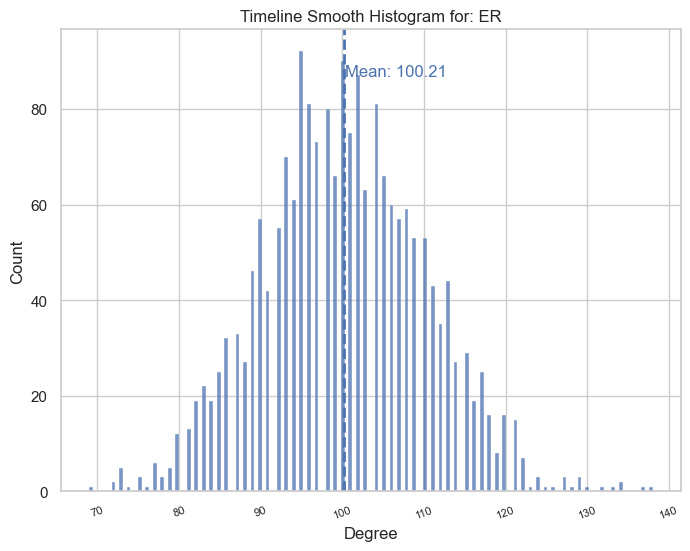

CPU times: user 1.03 s, sys: 49.3 ms, total: 1.08 s
Wall time: 922 ms


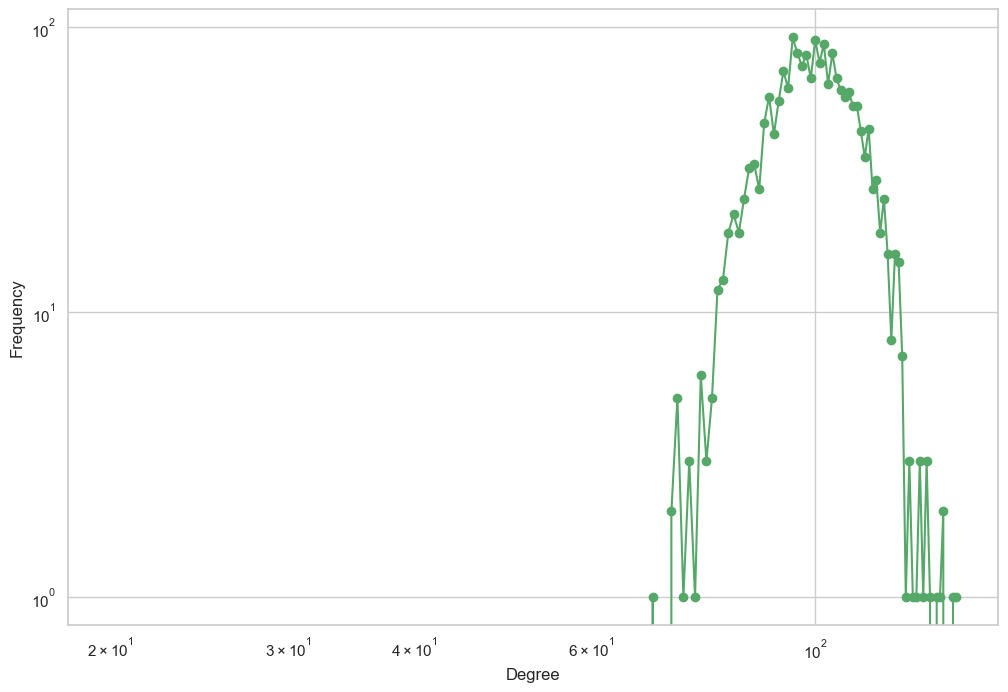

In [7]:
%%time
# Create a graph (example graph)
G_er = nx.gnp_random_graph(2000, 0.05)
# Plot its egree
plot_network_degree_distribution(G_er,'ER')
plot_loglog(G_er)

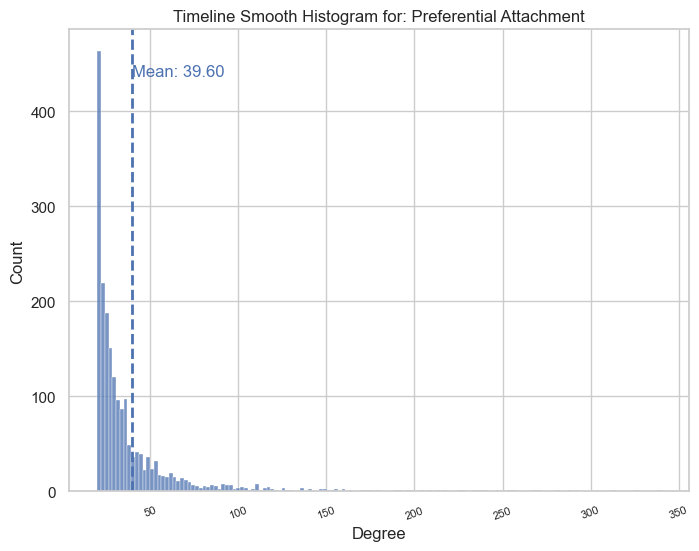

CPU times: user 770 ms, sys: 42.8 ms, total: 813 ms
Wall time: 687 ms


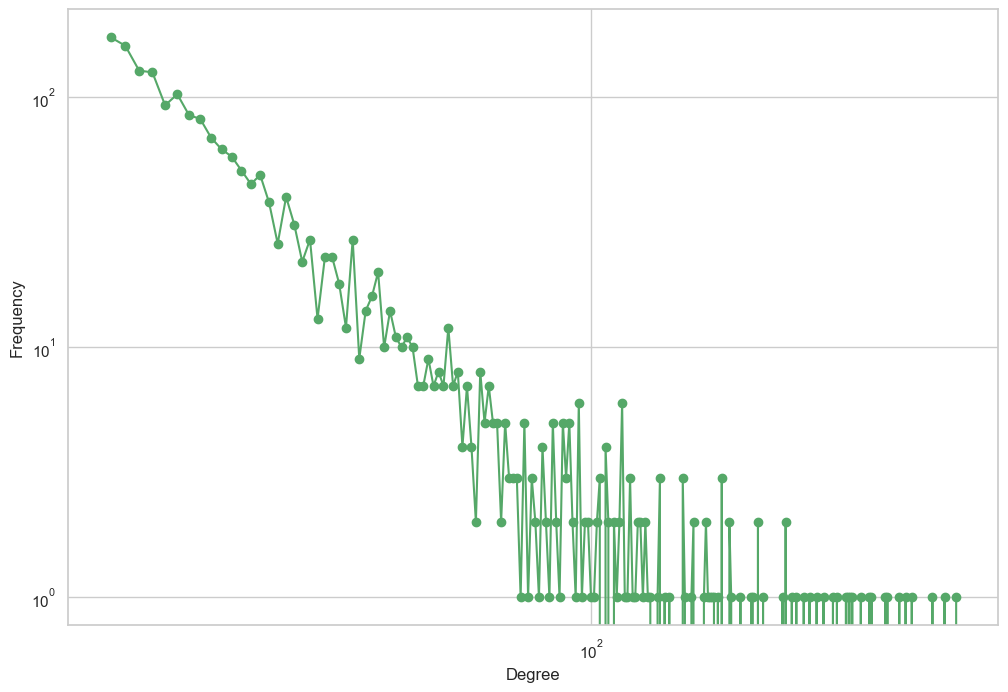

In [6]:
%%time
# Parameters for the graph
n = 2000  # Number of nodes
m = 20    # Number of edges to attach from a new node to existing nodes

# Generate the graph
G_ba = nx.barabasi_albert_graph(n, m)

plot_network_degree_distribution(G_ba,'Preferential Attachment')
plot_loglog(G_ba)

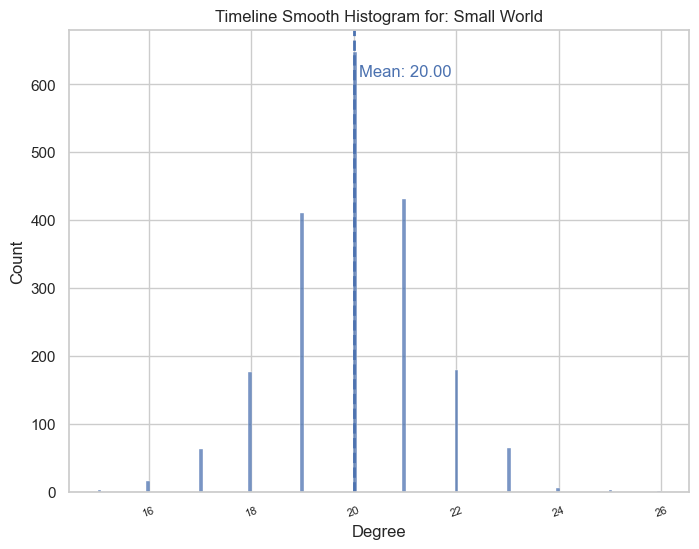

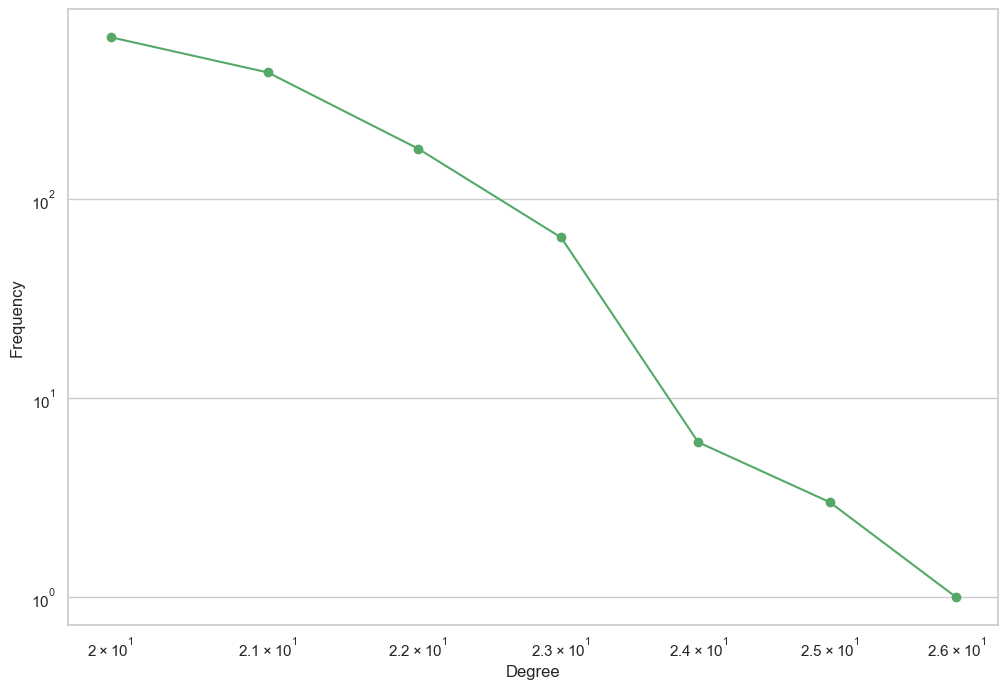

In [8]:
# Create a Watts-Strogatz small-world graph
n = 2000  # number of nodes
k = 20   # each node is connected to k nearest neighbors in ring topology
p = 0.1 # probability of rewiring each edge

G_ws = nx.watts_strogatz_graph(n, k, p, seed=42)
plot_network_degree_distribution(G_ws,'Small World')
plot_loglog(G_ws)

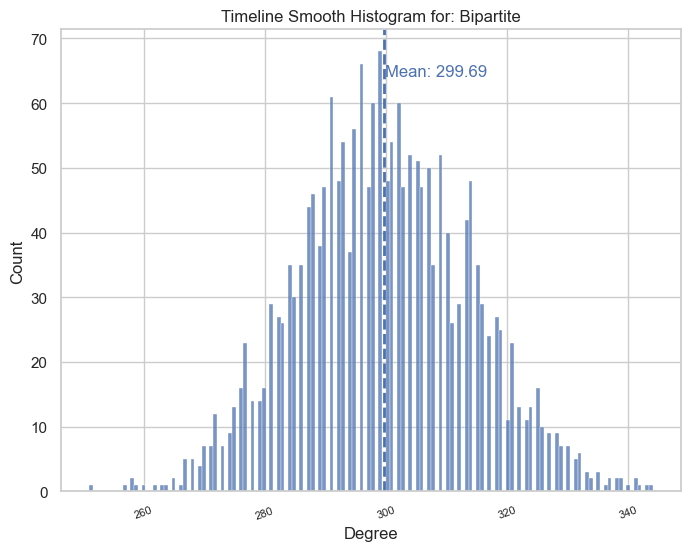

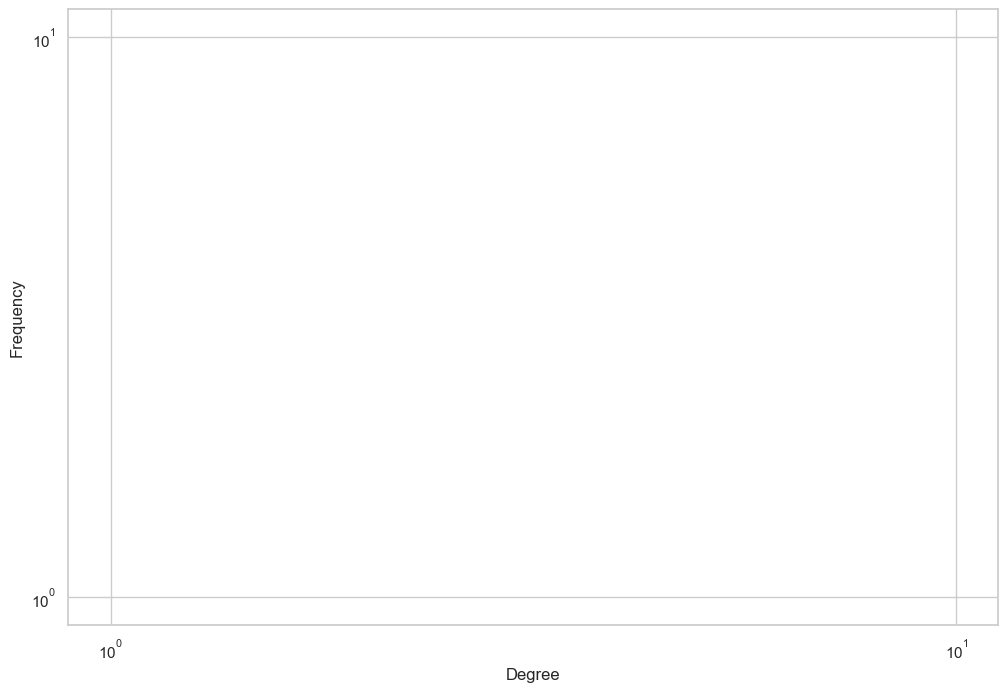

In [9]:
from networkx.algorithms import bipartite

# Parameters
n = 1000  # Number of nodes in the first set
m = 1000  # Number of nodes in the second set
p = 0.3  # Probability of edge creation

# Generate a random bipartite graph
B = nx.bipartite.random_graph(n, m, p, seed=42)

plot_network_degree_distribution(B,'Bipartite')

# Randomizing Network

In [10]:
def randomize_network_v2(G, p):
  edges = list(G.edges()).copy()
  rd.shuffle(edges)
  edges_set = set(edges)
  nodes = list(G.nodes()).copy()
  new_edges_set = set()
  to_remove_set = set()
  for old_edge in tqdm.tqdm(edges):
      if rd.random() < p:  # p probability to rewire an edge
          to_remove_set.add(old_edge)
          new_edge = (rd.choice(nodes),rd.choice(nodes))
          while (new_edge in new_edges_set) or (new_edge[0] == new_edge[1]):
              new_edge = (rd.choice(nodes),rd.choice(nodes))
          new_edges_set.add(new_edge)
  # Update the graph with new edges
  G_new = G.copy() # not doing this because it takes up memory
  G_new.remove_edges_from(list(to_remove_set))
  G_new.add_edges_from(list(new_edges_set))
  return G_new

## Rewiring example

100%|██████████| 149100/149100 [00:00<00:00, 1632007.87it/s]


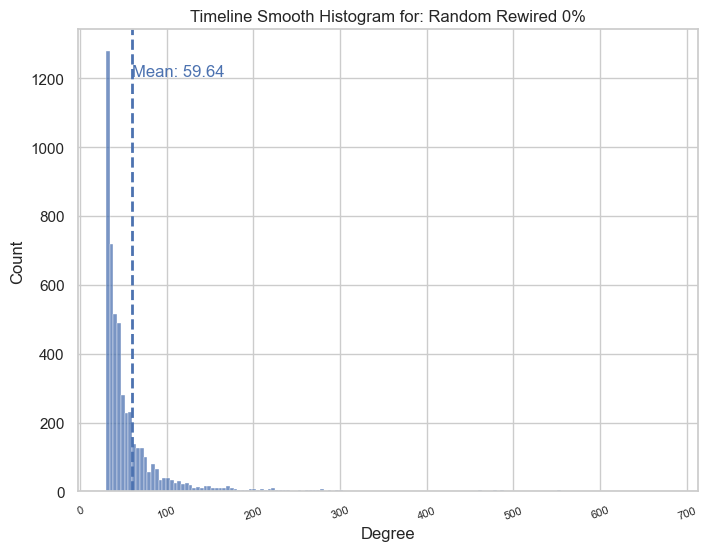

100%|██████████| 149100/149100 [00:00<00:00, 830383.21it/s]


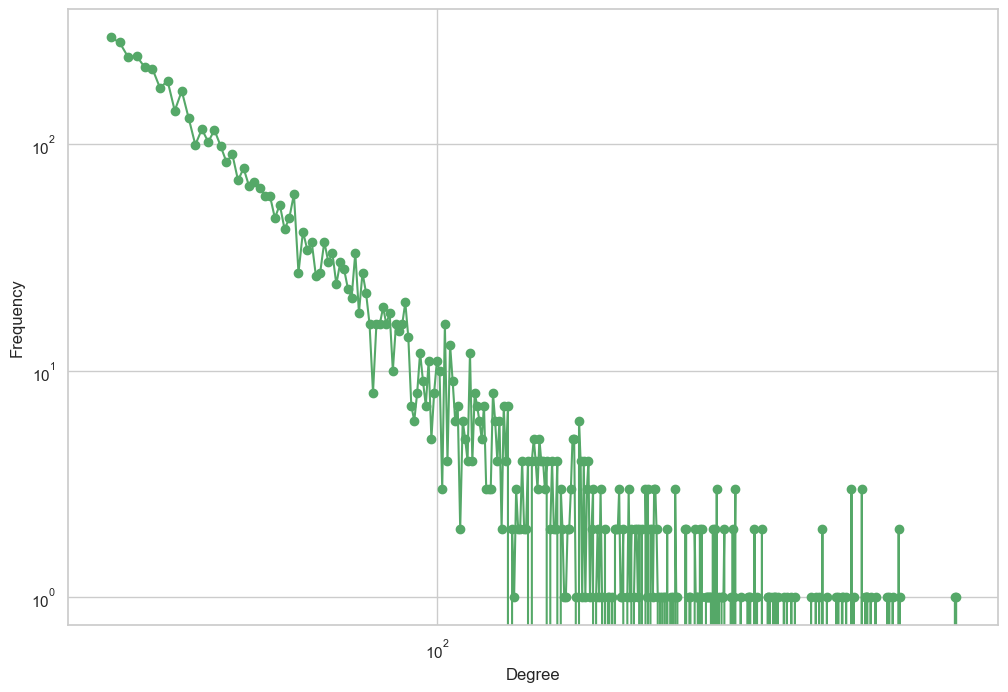

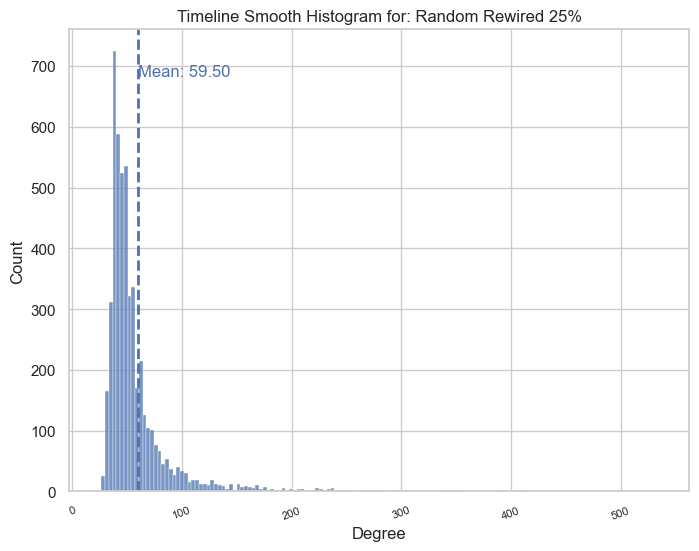

100%|██████████| 149100/149100 [00:00<00:00, 573699.87it/s]


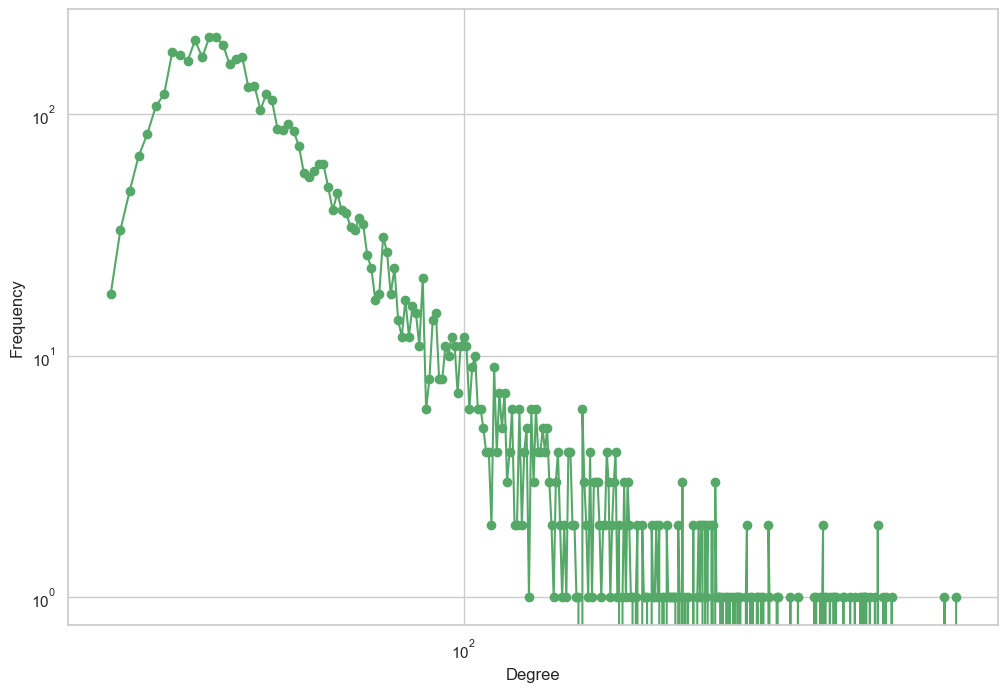

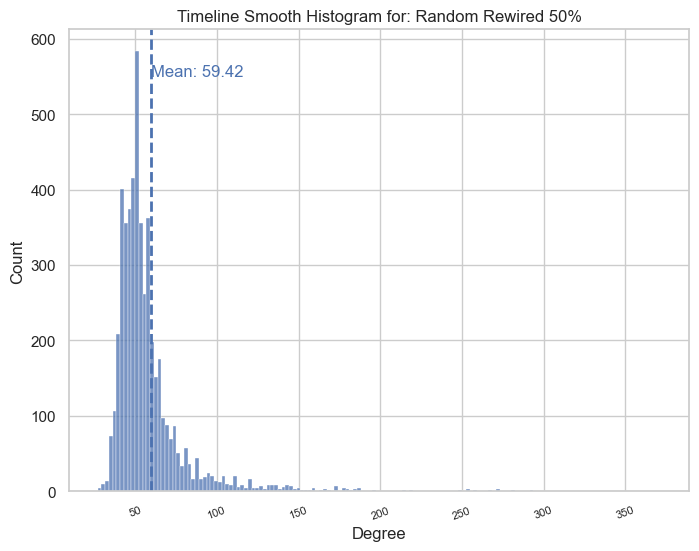

100%|██████████| 149100/149100 [00:00<00:00, 435919.93it/s]


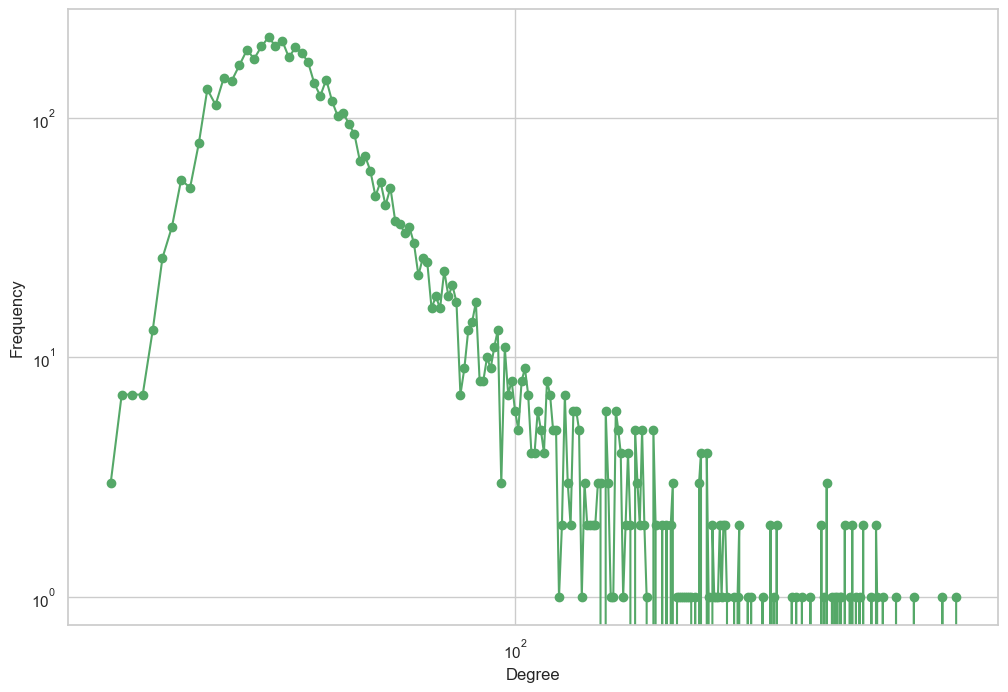

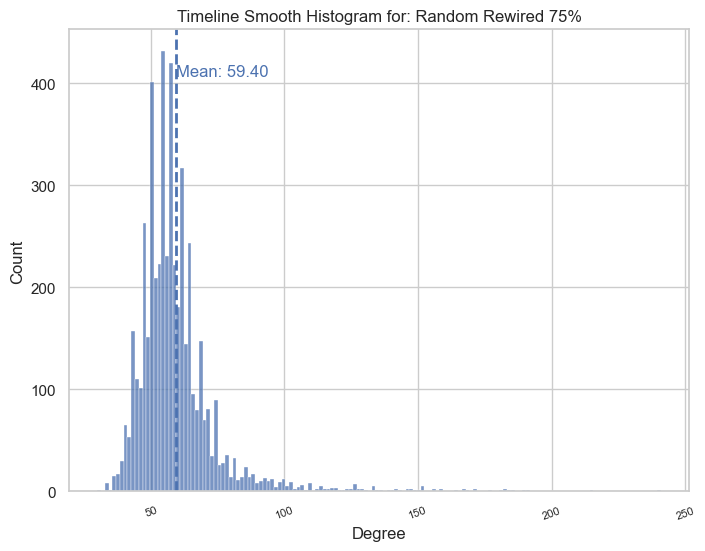

100%|██████████| 149100/149100 [00:00<00:00, 360140.54it/s]


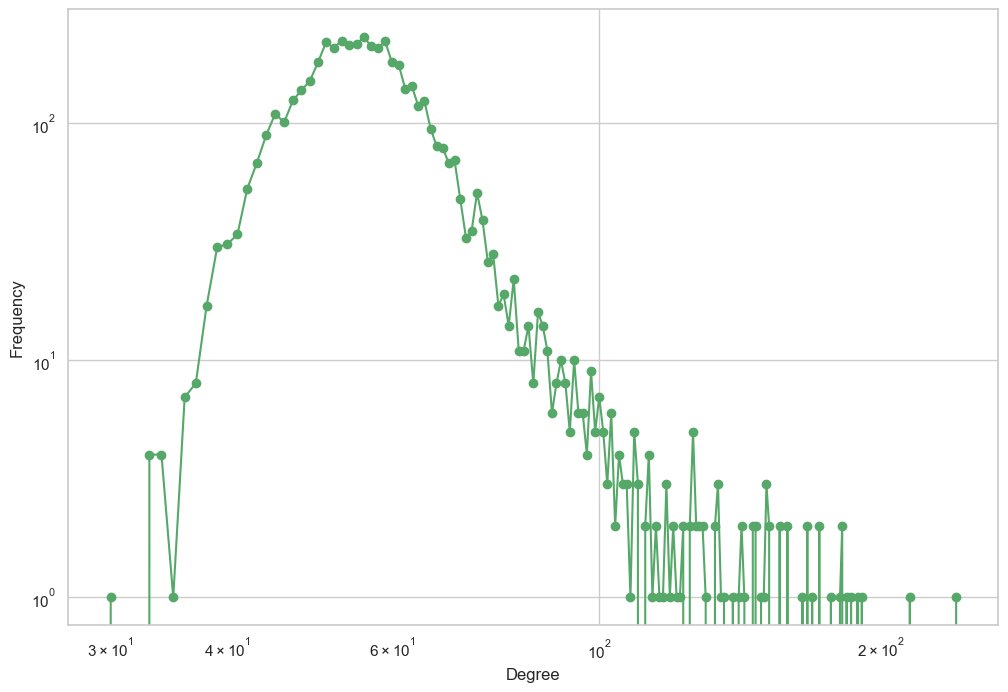

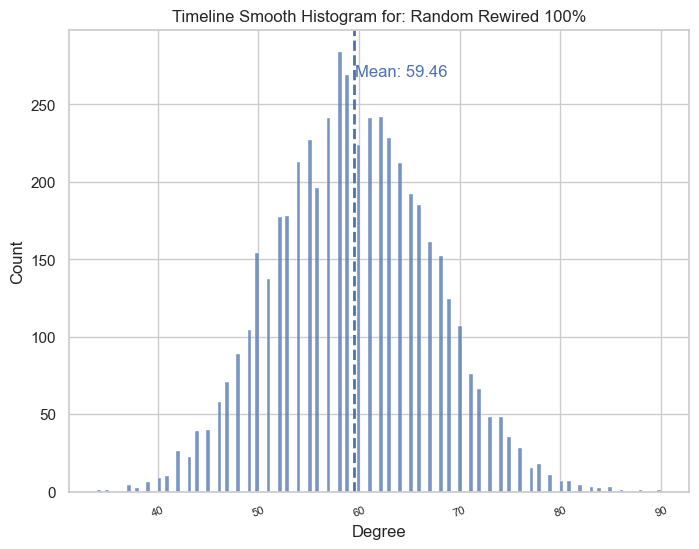

CPU times: user 12.1 s, sys: 414 ms, total: 12.5 s
Wall time: 12.2 s


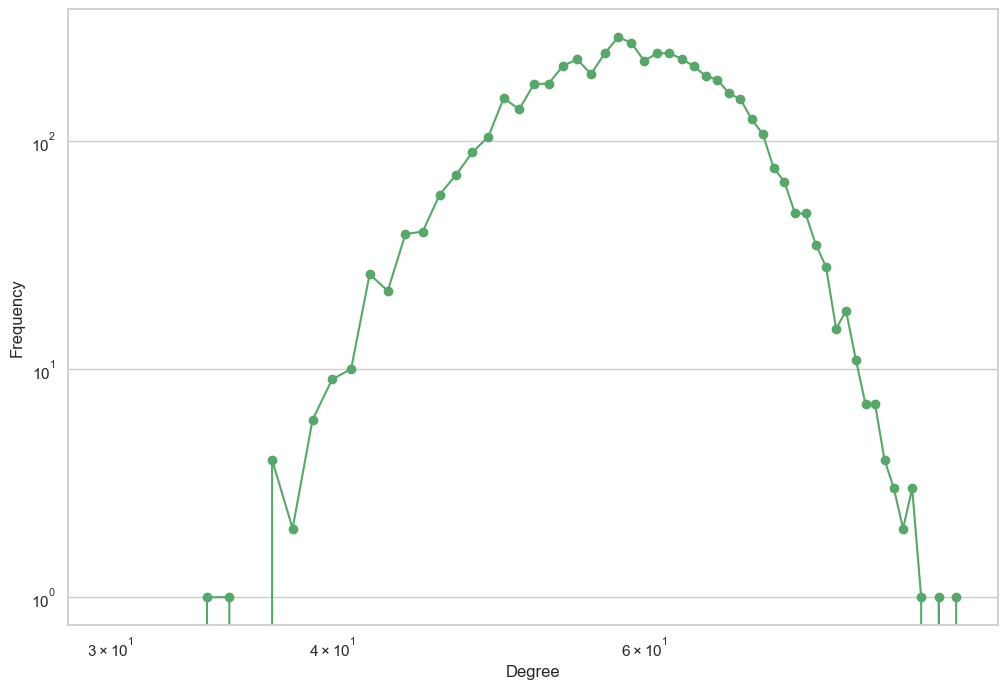

In [11]:
%%time
# Parameters for the graph
n = 5000  # Number of nodes
m = 30    # Number of edges to attach from a new node to existing nodes

# Generate the graph
G_ba = nx.barabasi_albert_graph(n, m)

G_rewired = randomize_network_v2(G_ba, 0)
plot_network_degree_distribution(G_rewired,'Random Rewired 0%')
plot_loglog(G_rewired)
G_rewired = randomize_network_v2(G_ba, 0.25)
plot_network_degree_distribution(G_rewired,'Random Rewired 25%')
plot_loglog(G_rewired)
G_rewired = randomize_network_v2(G_ba, 0.5)
plot_network_degree_distribution(G_rewired,'Random Rewired 50%')
plot_loglog(G_rewired)
G_rewired = randomize_network_v2(G_ba, 0.75)
plot_network_degree_distribution(G_rewired,'Random Rewired 75%')
plot_loglog(G_rewired)
G_rewired = randomize_network_v2(G_ba, 1)
plot_network_degree_distribution(G_rewired,'Random Rewired 100%')
plot_loglog(G_rewired)

# Centralizing Network

In [12]:
def rewire_network(network: nx.DiGraph, p_preferential_attachment: float):
    # Initialize network and nodes
    net = nx.DiGraph()
    net.add_nodes_from(network.nodes)

    # Hybrid attachment
    edges_to_do = list(network.edges()).copy()
    rd.shuffle(edges_to_do)
    for source, _ in edges_to_do:
        potential_targets = [
            node for node in net.nodes if node not in net[source] and node != source
        ]
        if not potential_targets:
            break

        if rd.random() < p_preferential_attachment:
            # Preferential attachment
            list_of_tuples = list(
                net.in_degree(potential_targets)
            )  # list of tuples of the form (node, in_degree of node)
            potential_targets_in_degrees = list(
                map(lambda tuple_item: tuple_item[1], list_of_tuples)
            )
            if all(w == 0 for w in potential_targets_in_degrees):
                # catches the case where all weights are zero
                target_new = rd.choice(potential_targets)
            else:
                target_new = rd.choices(
                    population=potential_targets,
                    weights=potential_targets_in_degrees,
                )[0]
                # Note on [0]: rd.choices produces a list
        else:
            # Random attachment
            target_new = rd.choice(potential_targets)
        net.add_edge(source, target_new)
    return net

In [13]:
def rewire_networkv2(G, p_preferential_attachment: float):
  # Actual edges
  edges = list(G.edges()).copy()
  rd.shuffle(edges)
  # Actual nodes
  nodes = list(G.nodes()).copy()
  rd.shuffle(nodes)

  # Rewire the edges
  new_edges = set()
  to_remove = set()

  # Hybrid attachment
  for source, target in edges:
      excluded_targets = G[source]
      potential_targets = [
          node for node in nodes if node not in excluded_targets and node != source
      ]
      if not potential_targets:
          break

      if rd.random() < p_preferential_attachment:
          to_remove.add((source, target))
          # Preferential attachment
          list_of_tuples = list(
              G.in_degree(potential_targets)
          )  # list of tuples of the form (node, in_degree of node)
          potential_targets_in_degrees = list(
              map(lambda tuple_item: tuple_item[1], list_of_tuples)
          )
          if all(w == 0 for w in potential_targets_in_degrees):
              # catches the case where all weights are zero
              target_new = rd.choice(potential_targets)
          else:
              target_new = rd.choices(
                  population=potential_targets,
                  weights=potential_targets_in_degrees,
              )[0]
              # Note on [0]: rd.choices produces a list

          new_edges.add((source, target_new))

  # Update the graph with new edges
  G_new = G.copy()
  G_new.remove_edges_from(to_remove)
  G_new.add_edges_from(new_edges)

  return G_new


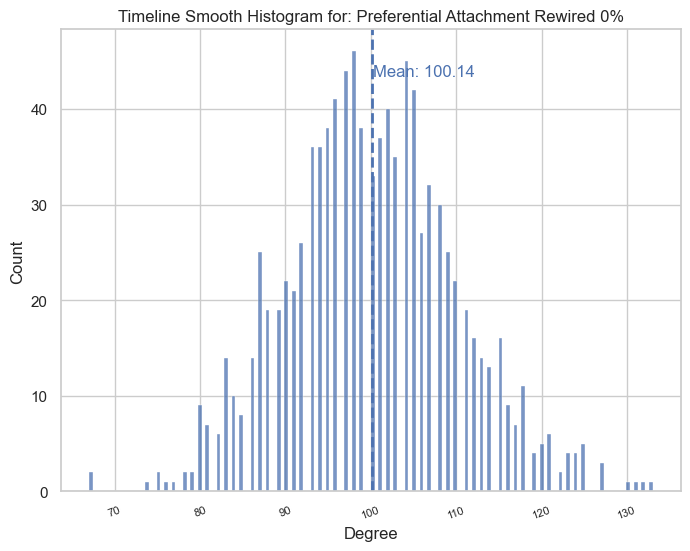

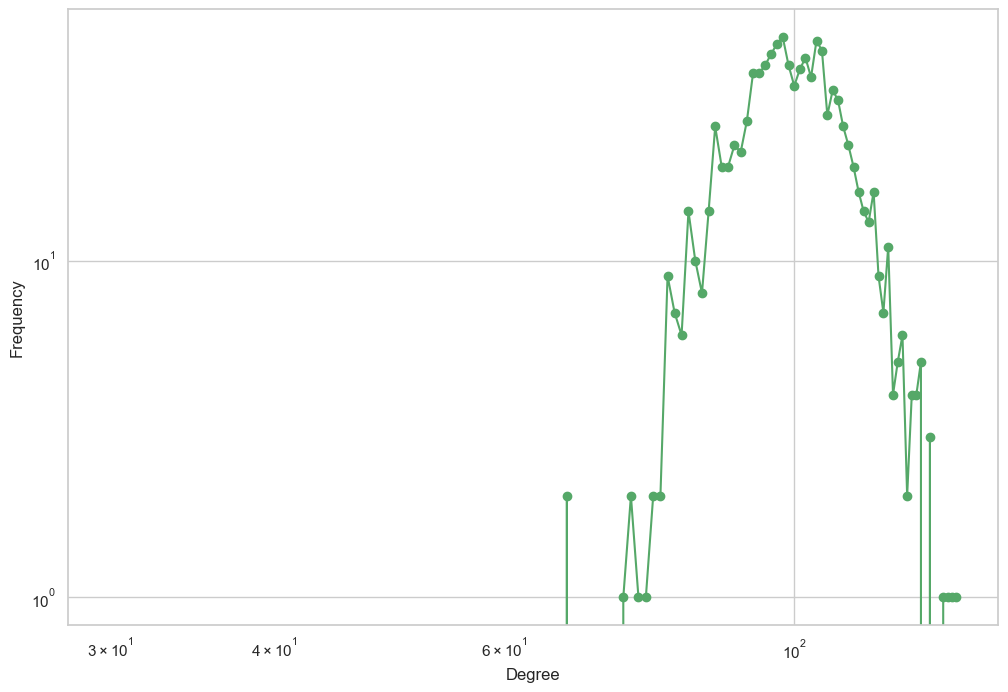

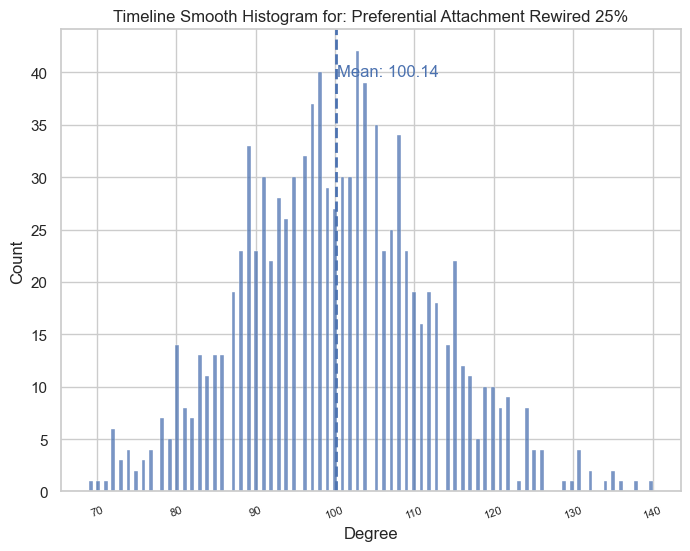

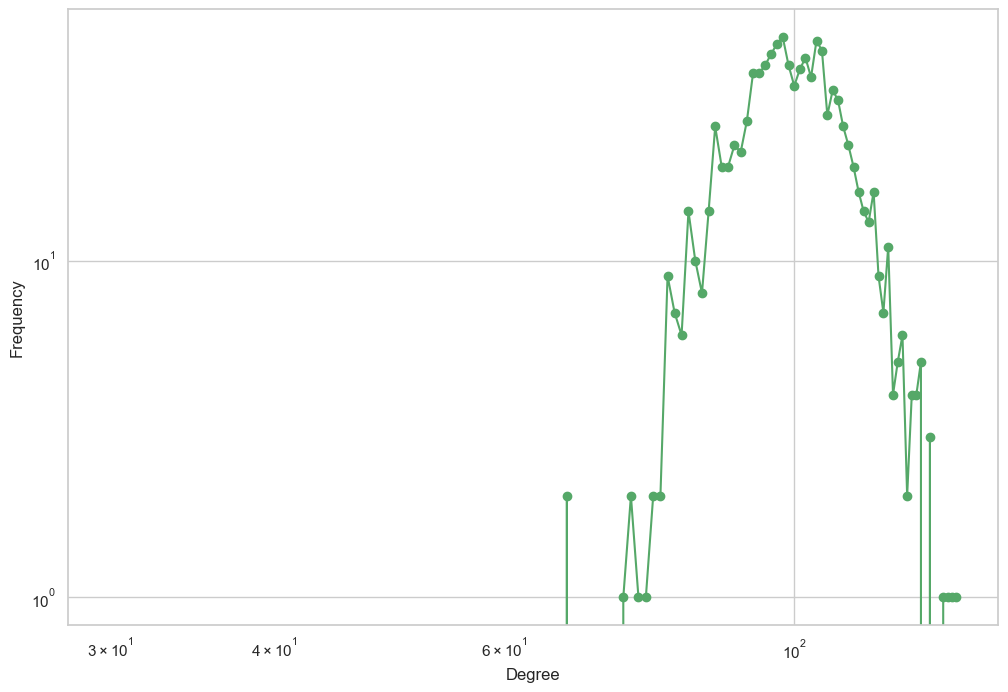

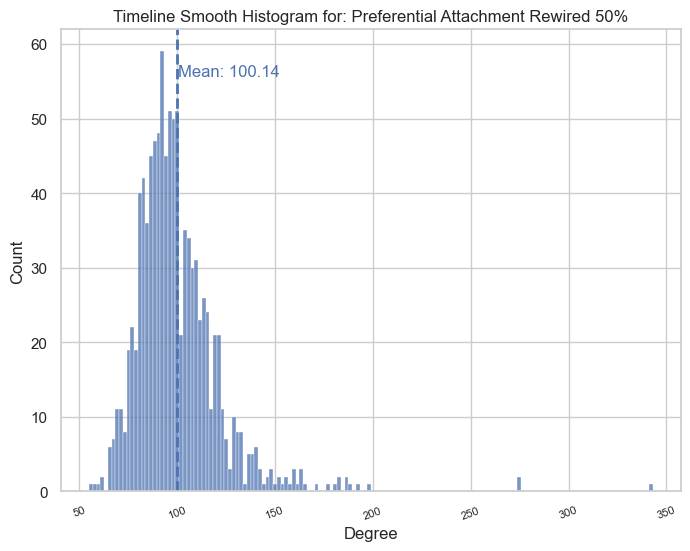

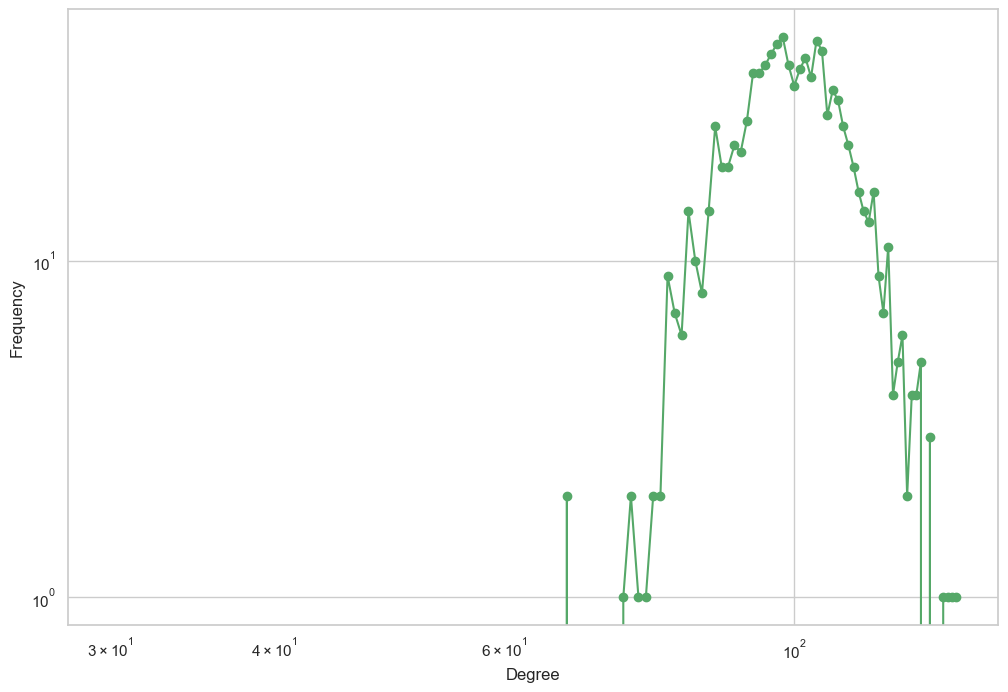

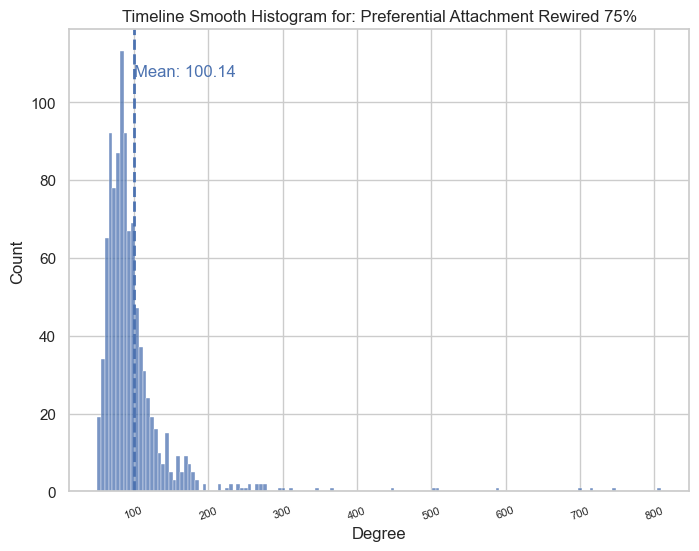

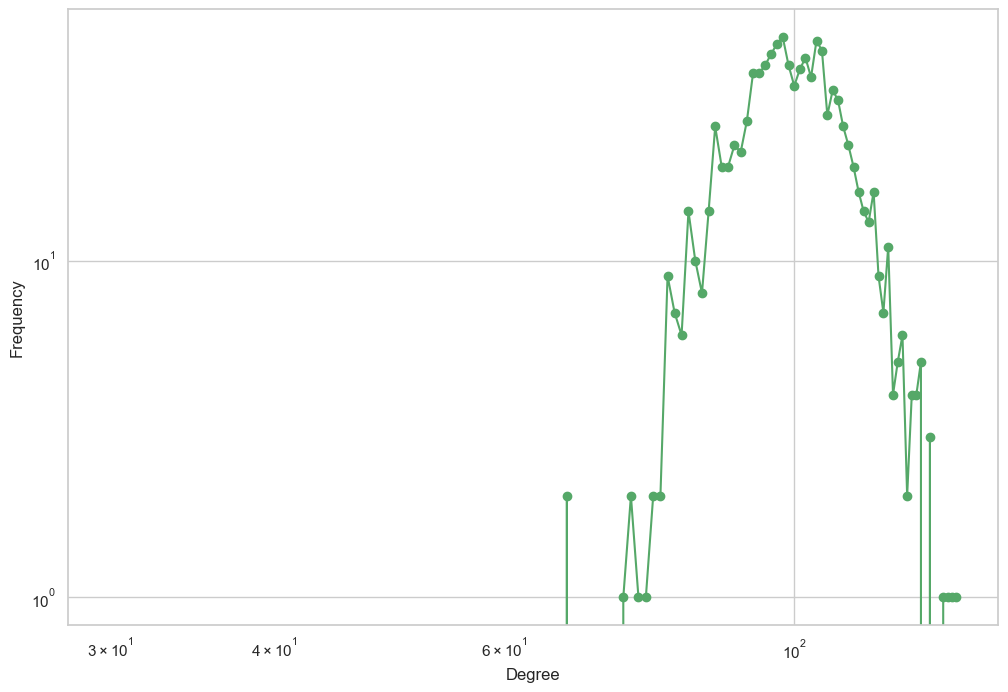

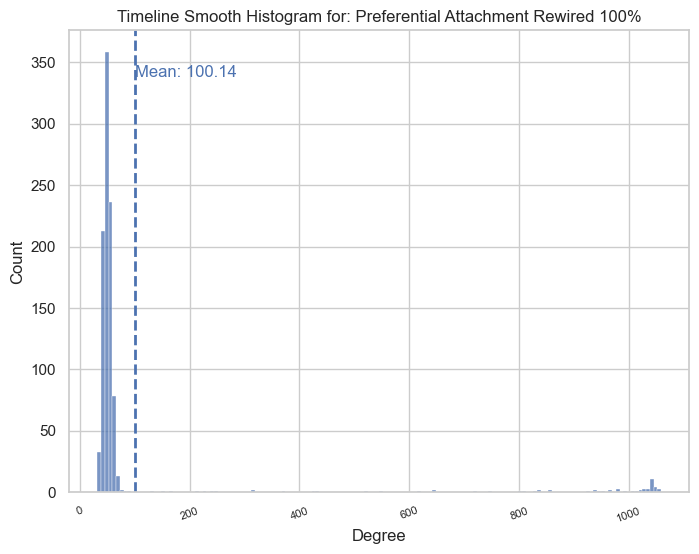

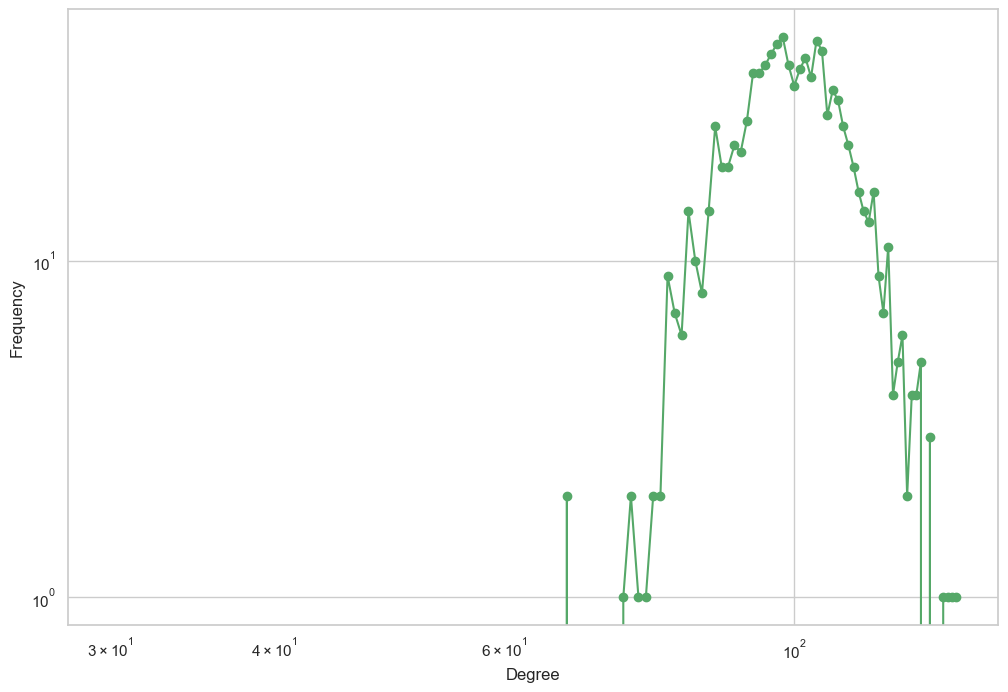

In [20]:
# Create a graph (example graph)
G_er = nx.gnp_random_graph(1000, 0.05, directed=True)
plot_network_degree_distribution(G_er,'Preferential Attachment Rewired 0%')
plot_loglog(G_er)
G_rewired = rewire_network(G_er, 0.25)
plot_network_degree_distribution(G_rewired,'Preferential Attachment Rewired 25%')
plot_loglog(G_er)
G_rewired = rewire_network(G_er, 0.50)
plot_network_degree_distribution(G_rewired,'Preferential Attachment Rewired 50%')
plot_loglog(G_er)
G_rewired = rewire_network(G_er, 0.75)
plot_network_degree_distribution(G_rewired,'Preferential Attachment Rewired 75%')
plot_loglog(G_er)
G_rewired = rewire_network(G_er, 1)
plot_network_degree_distribution(G_rewired,'Preferential Attachment Rewired 100%')
plot_loglog(G_er)